# ¿Qué tan importante es la fuente de ingresos de un solicitante de préstamo en línea?

In [1]:
import pandas as pd
import numpy  as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import interp
from statsmodels.formula.api import ols
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy.optimize import fsolve

#get_ipython().magic(u'matplotlib inline')

## Introduccion

**Contexto comercial.** Los préstamos en línea entre pares (P2P) han facilitado la práctica de pedir prestado y prestar. En esta forma de préstamo, no hay una entrevista en persona y un solicitante simplemente puede completar un formulario en línea y obtener la aprobación de un préstamo. La información proporcionada únicamente por el solicitante es propensa a la exageración y la distorsión, especialmente cuando se trata de ingresos. Cada empresa de préstamos P2P se basa en un procedimiento bien diseñado que rechaza a los prestatarios con una alta probabilidad de no pagar sus deudas.

Rechazar a cualquier persona sin una fuente de ingresos verificada es una política relevante que las plataformas de préstamos pueden implementar para ayudar a reducir la tasa de préstamos incobrables. Es natural sospechar que si la fuente de ingresos de una persona no se puede verificar, entonces podría dejar de pagar el préstamo. Sin embargo, desde la perspectiva de un solicitante, el proceso de verificación puede ser engorroso y llevar mucho tiempo y es posible que simplemente cambien a otra plataforma debido a este inconveniente.

**Problema comercial.** Como científico de datos en una empresa emergente de préstamos P2P, debe responder la siguiente pregunta: **"¿Debe la empresa verificar la fuente de ingresos de un solicitante de préstamo en línea antes de aprobar su préstamo?"**

**Contexto analítico.** Los datos se descargan de [Estadísticas de LendingClub](https://www.lendingclub.com/info/download-data.action) y contienen todos los préstamos emitidos entre 2007 y 2012 junto con su préstamo actual estado (totalmente pagado o cancelado). Hay ~50 variables que describen a los solicitantes y los préstamos; En aras de reducir la complejidad, la empresa ya ha realizado una preselección de estas variables en función de los análisis existentes de LendingClub para seleccionar nueve variables relevantes, como los ingresos anuales, la calificación crediticia de LendingClub, la propiedad de la vivienda, etc. Usaremos un nuevo técnica, **regresión logística**, para responder a nuestra pregunta en cuestión.

El caso está estructurado de la siguiente manera: 1) explorará los datos existentes para tener una idea aproximada de cómo interactúa cada variable en el conjunto de datos con el estado actual del préstamo; 2) examinar los posibles efectos de confusión; 3) aprender los conceptos básicos de los modelos de regresión logística; y finalmente 4) ajuste una serie de modelos de regresión logística para determinar si la verificación de la fuente de ingresos es significativa o no.

## Exploración de data

In [2]:
df = pd.read_csv("Lending_club_cleaned_2.csv")
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=["Charged Off", "Fully Paid"]))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=["< 1 year", "1 year", "2 years", "3 years", "4 years", \
                                                             "5 years", "6 years", "7 years", "8 years", "9 years", \
                                                             "10+ years"]))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=["RENT", "MORTGAGE","OWN","OTHER"]))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[" 36 months", " 60 months"]))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=["A","B","C","D","E","F","G"]))
df.int_rate = df.int_rate.str.rstrip("%").astype("float")

In [3]:
df.shape

(38705, 10)

In [4]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


Tenemos 38706 registros de transacciones pasadas en este conjunto de datos. Cada registro corresponde a un préstamo aprobado. La primera columna indica si el solicitante canceló el préstamo (pagado en su totalidad) o no (cancelado). Las descripciones de las otras nueve columnas son las siguientes:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

### Relaciones entre `loan_status` y otras variables

Primero realizamos EDA para examinar la relación por pares entre `loan_status` y cada una de las otras variables. Tenemos variables discretas y continuas en el conjunto de datos. Consideremos primero las variables continuas.

### Ejercicio 1

Utilice la función `boxplot()` del paquete `seaborn` para visualizar las distribuciones de `annual_inc`, `int_rate` y `loan_amnt` en usuarios que pagaron completamente sus deudas frente a aquellos que no lo hicieron. ¿Ves una gran diferencia en las distribuciones?

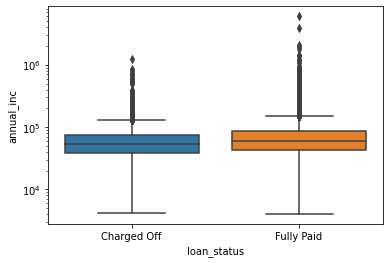

In [5]:
sns.boxplot(y="annual_inc", x="loan_status", data = df).set_yscale('log');

Podemos ver un ligero aumento en la media de los ingresos anuales cuando se comparan los usuarios totalmente pagados con los usuarios cancelados.

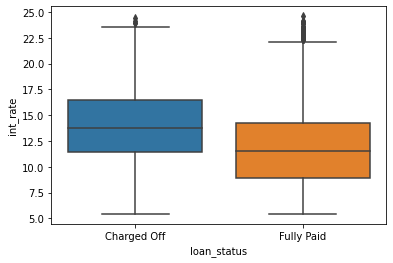

In [6]:
sns.boxplot(y="int_rate", x ='loan_status', data = df);

La diferencia entre usuarios cancelados y usuarios totalmente pagados en la distribución de `int_rate` es más drástica. El diagrama de caja para los usuarios totalmente pagados es más bajo que el de los usuarios cancelados. Este resultado es el esperado, ya que las tasas de interés más altas aumentarían la cantidad real de dinero que un usuario tiene que pagar.

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

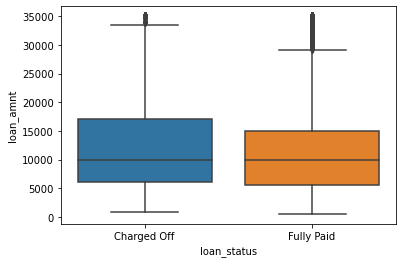

In [7]:
sns.boxplot(y="loan_amnt", x ='loan_status', data = df)

No vemos un cambio claro en la distribución de `loan_amnt`. Los usuarios que pagaron por completo sus deudas parecen tener una cantidad ligeramente menor de préstamos en promedio.

Aprendimos en casos anteriores de prueba de hipótesis que podemos usar tablas de contingencia para examinar la relación entre dos variables discretas. Se puede realizar una prueba de chi-cuadrado basada en la tabla de contigencia para verificar si la relación observada es estadísticamente significativa. Examinemos todas las variables discretas en nuestro conjunto de datos.

### Ejercicio 2

Escribe una función para generar la tabla de contingencia entre `loan_status` y otra variable llamada `var`. Asegúrese de incluir una columna para la proporción de usuarios totalmente pagados en cada nivel de `var`. Utilice esta función para generar las tablas de contingencia para examinar las relaciones entre `loan_status` y todas las variables discretas en el conjunto de datos.

In [8]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res["Fully Paid(%)"] = round( ct_res["Fully Paid"]/ct_res["All"]*100, 2)
    return ct_res.drop(columns="All")

In [9]:
get_ct( df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


In [10]:
get_ct( df, 'emp_length' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
emp_length,,,
< 1 year,641,3947,86.03
1 year,460,2787,85.83
2 years,571,3823,87.01
3 years,558,3540,86.38
4 years,466,2978,86.47
5 years,459,2826,86.03
6 years,309,1922,86.15
7 years,263,1512,85.18
8 years,206,1279,86.13


In [11]:
get_ct( df, 'home_ownership' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
home_ownership,,,
RENT,2752,15755,85.13
MORTGAGE,2268,14987,86.86
OWN,402,2443,85.87
OTHER,18,80,81.63
All,5440,33265,85.94


In [12]:
get_ct( df, 'purpose' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
purpose,,,
car,155,1344,89.66
credit_card,516,4491,89.69
debt_consolidation,2703,15572,85.21
educational,52,265,83.60
home_improvement,333,2554,88.47
house,59,310,84.01
major_purchase,211,1905,90.03
medical,101,569,84.93
moving,84,475,84.97


In [13]:
get_ct( df, 'term' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
term,,,
36 months,3073,25211,89.14
60 months,2367,8054,77.29
All,5440,33265,85.94


In [14]:
get_ct( df, 'grade' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
grade,,,
A,558,9136,94.24
B,1362,10335,88.36
C,1296,6642,83.67
D,1097,4116,78.96
E,710,2101,74.74
F,317,718,69.37
G,100,217,68.45
All,5440,33265,85.94


### Ejercicio 3

Según las tablas de contingencia anteriores, ¿qué variables parecen tener asociaciones con `loan_status`? Utilice la prueba de chi-cuadrado para verificar si las asociaciones observadas son estadísticamente significativas.

In [15]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['verification_status'], df['loan_status']))
print('verification_status: p-value del chisquare test =', p)

verification_status: p-value del chisquare test = 6.884998281535999e-17


In [16]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['emp_length'], df['loan_status']))
print('emp_length: p-value del chisquare test =', p)

emp_length: p-value del chisquare test = 0.06419956286286349


In [17]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['home_ownership'], df['loan_status']))
print('home_ownership: p-value del chisquare test =', p)

home_ownership: p-value del chisquare test = 3.094754275730736e-05


In [18]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['purpose'], df['loan_status']))
print('purpose: p-value del chisquare test =', p)

purpose: p-value del chisquare test = 6.53325963877868e-71


In [19]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['term'], df['loan_status']))
print('term: p-value del chisquare test =', p)

term: p-value del chisquare test = 2.7851291583847273e-194


In [20]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['grade'], df['loan_status']))
print('grade: p-value del chisquare test =', p)

grade: p-value del chisquare test = 0.0


Parece que todas las variables consideradas anteriormente están asociadas con `loan_status` ya que las proporciones de usuarios totalmente pagados no son las mismas en todos los niveles de estas variables. En particular, la variable que más nos importa, `verification_status`, parece tener una asociación contraria a la intuición con `loan_status`: cuanto menos confiable es la información de ingresos, más probable es que un usuario pague la deuda en su totalidad, como se refleja en la tendencia decreciente de las proporciones totalmente pagadas cuando `verification_status` aumenta de no verificado a totalmente verificado. Las pruebas de chi-cuadrado verifican que todas estas asociaciones observadas, excepto `emp_length`, son estadísticamente significativas.

### Ejercicio 4

Con base en los resultados anteriores, ¿cuáles de las siguientes afirmaciones son correctas? Seleccione todas las que correspondan.

1. Hay una disminución de 2.5 en promedio en la tasa de interés en los usuarios que pagaron íntegramente sus deudas en comparación con los usuarios que no lo hicieron.
2. No existe una asociación estadísticamente significativa entre `emp_length` y `loan_status`, ya que la proporción de usuarios totalmente pagados sigue siendo relativamente la misma en los diferentes niveles de `emp_length`.
3. Dado que la prueba de chi-cuadrado para la tabla de contingencia de `verification_status` frente a `loan_status` es significativa, la tendencia decreciente de la probabilidad de pago probablemente no se deba a la aleatoriedad.
4. Dado que existe una diferencia significativa entre la probabilidad de pago completo en usuarios sin ingresos verificados y usuarios con ingresos verificados según la prueba de chi-cuadrado, siempre debemos aplicar la verificación de ingresos.

**Respuesta.** 

1 es correcto como lo indican los diagramas de caja. 

2 no es correcto ya que la conclusión debe extraerse con base en la prueba de chi-cuadrado (que no es significativa). 

3 no es correcto. La prueba de chi-cuadrado no es una prueba de tendencia, solo sugiere que existe una diferencia significativa en la probabilidad de pago entre los tres niveles de `verification_status`, pero no puede verificar que las diferencias formen una tendencia específica. 

4 no es correcto ya que implica una relación causal entre `verification_status` y `loan_status`. No hay suficiente evidencia para deducir esto, y primero debemos evaluar posibles variables de confusión como hicimos en casos anteriores antes de llegar a una conclusión tan sólida.

### Tablas de contigencia estratificadas de `verification_status` vs `loan_status`

Como vimos en el ejercicio anterior, necesitamos ajustar otras variables para eliminar posibles impactos de confusión. Si queremos saber si `verification_status` realmente está asociado con `loan_status` como lo indica la tabla de contingencia anterior, deberíamos considerar estratificar la tabla de contingencia entre `loan_status` y `verification_status` por otras variables que también están asociadas con `loan_status` .

### Ejercicio

Escriba una función para generar una tabla de contingencia para `verification_status` frente a `loan_status` estratificado por `stra_var`. (Sugerencia: si `index` incluye dos variables, la tabla de contingencia se estratificará por la primera variable). Asegúrese de incluir una columna para la proporción de usuarios totalmente pagados en cada nivel de `verification_status`. Utilice esta función para examinar la relación entre `verification_status` y `loan_status` al ajustar `home_ownership` y `term`. ¿Seguimos viendo la misma tendencia en los diferentes niveles de `propiedad_de_casa` y `plazo`?

In [21]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra["Fully Paid (%)"] = round(ct_stra["Fully Paid"]/ct_stra["All"]*100,2)
    return ct_stra.drop(columns="All").drop("All", level=0)

In [22]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56

In [23]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

Podemos ver que la tendencia se conserva cuando se estratifica por `home_ownership`. La proporción de usuarios fully disminuye a medida que el estado de verificación se vuelve menos confiable, independientemente de los niveles de `home_ownership`. La excepción es el nivel `OTHER`. Pero como tenemos muy pocos usuarios allí, no debemos confiar demasiado en los resultados. La tendencia ya no se conserva en ambos niveles de `term`. Podemos ver que la proporción de usuarios fully paid con un plazo de préstamo más corto (36 meses) sigue siendo la misma en diferentes niveles de "estado de verificación" en alrededor del 88%.

### Ejercicio 6

Al comparar las tablas de contigencia estratificadas con las contrapartes no estratificadas, ¿cuál de las siguientes conclusiones es correcta? Seleccione todas las que correspondan.

1. Con base en la tabla de contingencia estratificada, la diferencia en la probabilidad de pago total entre los usuarios con ingresos verificados y los no verificados podría atribuirse al efecto del plazo del préstamo sobre la probabilidad de pago total.
2. Con base en la tabla de contingencia estratificada, la diferencia en la probabilidad de pago total entre usuarios con ingresos verificados y no verificados probablemente no sea atribuible al efecto de la propiedad de la vivienda en la probabilidad de pago total.
3. Suponga que es más probable que los usuarios sin ingresos verificados soliciten préstamos a corto plazo en comparación con los usuarios con ingresos verificados y que los usuarios con préstamos a corto plazo tengan más probabilidades de pagar sus deudas. Si, de hecho, el estado de verificación de ingresos no tiene efecto sobre la probabilidad de pagar la deuda, los usuarios sin ingresos verificados tienen aún más probabilidades de pagar su deuda.

**Respuesta.** 

1 es correcto. Como vemos en la tabla estratificada por `term`, la proporción de préstamos pagados en su totalidad sigue siendo la misma en los diferentes niveles de estado de verificación cuando se fija el `term`. Por otra parte, la probabilidad de pago total específica del estrato es bastante diferente de un estrato a otro. 

2 es correcto ya que estratificar la tabla de contingencia por `home_ownership` no cambia significativamente las proporciones de los préstamos pagados en su totalidad. 

3 es correcto por definición y, de hecho, podría ser la razón por la que observamos la tendencia contraria a la intuición. Podemos ver que los usuarios sin ingresos verificados tienen muchos más préstamos a corto plazo, mientras que la tabla de contingencia estratificada nos indicó que los usuarios con préstamos a más largo plazo tienen menos probabilidades de pagar sus deudas en comparación con los prestatarios de préstamos a corto plazo.


In [24]:
pd.crosstab(df['term'], df['verification_status'])

verification_status,Not Verified,Source Verified,Verified
term,,,
36 months,14154,6820,7310
60 months,2345,2999,5077


## Regresión logística: extendiendo el modelo lineal a resultados binarios

A partir de la prueba de chi-cuadrado, sabemos que el estado de verificación está marginalmente asociado con la probabilidad de pago. Observamos a partir de la tabla de contingencia que esta probabilidad aumenta cuando la información sobre los ingresos se vuelve menos confiable. Sin embargo, esta observación no se puede verificar solo con la prueba estándar de chi-cuadrado.

Introducimos el modelo de regresión logística para examinar si esta tendencia es significativa. El modelo de regresión logística es una versión modificada del modelo de regresión lineal estándar que se ocupa de problemas de clasificación, donde los resultados son variables binarias (en este caso, si el préstamo se pagó o no). Para comprender un modelo de regresión logística, primero introduzcamos la idea de probabilidades. La probabilidad de un evento es la relación entre su probabilidad de éxito y su probabilidad de fracaso. En nuestro caso, la probabilidad de pagar la deuda en su totalidad se define como

$$
\text{Odds}(\text{Full payment}) = \frac{p}{1-p}.
$$

donde $p$ es la probabilidad de pagar

Resulta que es más fácil trabajar con cuotas que con probabilidades. Para investigar nuestra pregunta sobre la tendencia en la probabilidad de pago $p$, asumimos que las probabilidades son una función del estado de verificación de ingresos:

\begin{equation}
\log(\text{Odds}) = \beta_0 + \beta_1*\text{verification_status}. \tag{1}
\end{equation}

Para reflejar que hay una tendencia sobre los diferentes estados de verificación, codificamos diferentes niveles de `verification_status` usando números enteros: "No verificado" como 0, "Fuente verificada" como 1 y "Verificado" como 2; es decir, estamos renombrando categorías de una variable categórica para reflejar una tendencia numérica clara. Afirmamos que este esquema de codificación implica que si $\beta_1$ es positivo, entonces hay una tendencia creciente de probabilidad de pago a medida que el estado de verificación de ingresos se vuelve más confiable. Por otro lado, si $\beta_1$ es negativo, ocurre lo contrario.

Una vez que ajustamos el modelo en (1), podemos realizar una prueba para examinar si $\beta_1$ es significativamente diferente de cero. Tenga en cuenta que si $\beta_1=0$, entonces $p$ es el mismo para diferentes niveles de `verification_status` y, por lo tanto, no hay ninguna tendencia presente. Si $\beta_1$ es significativamente diferente de cero, podemos usar el signo estimado de $\beta_1$ para determinar la dirección de la tendencia.

### Interpretación numérica de regresión logística

Aunque el modelo de regresión logística tiene más complejidad que la regresión lineal estándar, el signo del coeficiente de regresión aún representa la dirección de influencia de una variable específica: un coeficiente positivo significa que la probabilidad de pago aumentará si la variable asociada aumenta y viceversa. viceversa

La otra parte importante de la información al interpretar un modelo de regresión logística es el valor $p$ para cada coeficiente de regresión. El valor p indica el resultado de la siguiente prueba de hipótesis:

$$
H_0: \beta = 0~vs.~ H_A: \beta \neq 0.
$$

La prueba determina si la diferencia en la probabilidad de pago está asociada con cambios en la variable correspondiente.

A veces puede encontrar que tanto el valor de $p$ como el tamaño del efecto estimado (coeficiente de regresión) para una variable son pequeños. Debe tener cuidado con esta situación ya que $p$: los valores no son la única forma de determinar si las variables son importantes.

### Interpretación geométrica de la regresión logística 

La perspectiva geométrica de los modelos de regresión logística también es crucial, ya que un modelo de regresión logística define naturalmente un "límite de decisión". Si especificamos que $p$ es más bajo que un límite de límite de decisión dado, donde $p_0$ (por ejemplo, 0.5) indica morosos, entonces (1) indica que las muestras con $\beta_0 + \beta_1*verification\_status>\log (p_0)/(1-\log(p_0))$ no son morosos y $\beta_0 + \beta_1*verification\_status<\log(p_0)/(1-\log(p_0))$ son morosos. La línea que separa a los morosos de los no morosos, que está definida por la ecuación $\beta_0 + \beta_1*verification\_status=\log(p_0)/(1-\log(p_0))$ es el límite de decisión determinado por el modelo (1) y valor de corte $p_0$.

Asumimos que $p$ es determinado por el siguiente modelo:

$$
\log(p/(1-p)) = 2*loan\_amnt - annual\_inc.
$$

Aquí `annual_inc` se divide entre $10^4$ y `loan_amnt` se divide entre $1000$. La línea $2*loan\_amnt = annula\_inc$ en este caso separa a los morosos de los no morosos y es el límite de decisión con una probabilidad de corte de 0.5:

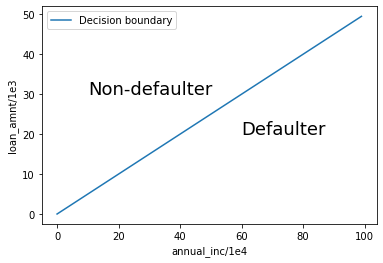

In [25]:
x = np.arange(0,100,1)
y = x/2
plt.plot(x, y, label = "Decision boundary");
plt.xlabel("annual_inc/1e4");
plt.ylabel("loan_amnt/1e3");
plt.text(10, 30, "Non-defaulter", fontsize = 18)
plt.text(60, 20, "Defaulter", fontsize = 18)
plt.legend();

La forma del límite de decisión en la regresión logística no siempre es una línea; a menudo, es una curva.

### Visualización del límite de decisión

Consideramos el siguiente modelo logistico para $p$:

$$
\log(p/(1-p)) = \beta_0 + \beta_1*loan\_amnt+\beta_2*annual\_inc+\beta_3*loan\_amnt^2.
$$

Sabemos que el límite de decisión correspondiente con valor de corte $p = 0.5$ es

$$
\beta_0 + \beta_1*loan\_amnt+\beta_2*annual\_inc+\beta_3*loan\_amnt^2 = 0.
$$

Utilice la siguiente gráfica interactiva para ajustar los parámetros y ver cómo cambia el límite de decisión:

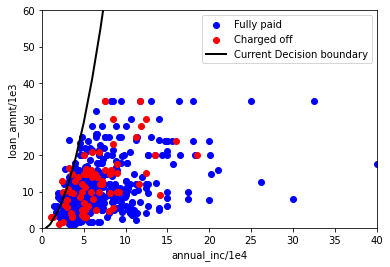

interactive(children=(FloatSlider(value=1.0, description='beta0', max=10.0, min=-10.0, step=0.5), FloatSlider(…

In [35]:
#%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact

idx_plot = np.random.choice(df.shape[0], size=500, replace = False)
plt_data = df.iloc[idx_plot]

fig, ax = plt.subplots()
#plt.subplots_adjust(left=0.25, bottom=0.35)
plt.scatter(plt_data[plt_data.loan_status=="Fully Paid"].annual_inc/10000, \
            plt_data[plt_data.loan_status=="Fully Paid"].loan_amnt/1000, \
            c = 'blue', label = 'Fully paid')
plt.scatter(plt_data[plt_data.loan_status=="Charged Off"].annual_inc/10000, \
            plt_data[plt_data.loan_status=="Charged Off"].loan_amnt/1000, \
            c = 'red', label = 'Charged off')
plt.xlim(0,40);
plt.legend();

#plot boundary
beta0 = 1
beta1 = -1
beta2 = 1
beta3 = -1

x_plt = np.arange(0,40,1)
y_plt = (-beta0 - beta1*x_plt - beta3*x_plt**2)/(beta2)
plt.xlabel("annual_inc/1e4")
plt.ylabel("loan_amnt/1e3")
l, = plt.plot(x_plt, y_plt, lw = 2, color="k", label = "Current Decision boundary")
plt.ylim(0,60);
plt.legend();

def update(beta0=1, beta1=-1, beta2=1, beta3=-1):
    y_plt = (-beta0 - beta1*x_plt - beta3*x_plt**2)/(beta2)
    l.set_ydata(y_plt);
    fig.canvas.draw_idle();

interact(update, beta0 = widgets.FloatSlider(value=beta0,min=-10,max=10,step=0.5),\
         beta1 = widgets.FloatSlider(value=beta1,min=-10,max=10,step=0.5),
         beta2 = widgets.FloatSlider(value=beta2,min=0.5,max=10,step=0.5),
         beta3 = widgets.FloatSlider(value=beta3,min=-10,max=0,step=0.5));

In [34]:
%matplotlib inline

## Ajuste del modelo de regresión logística 

Ahora ajustamos el modelo logístico utilizando el paquete `statmodels` con la especificación que describimos anteriormente:

In [36]:
# codificar la variable discreta según la especificación anterior
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
print( logit_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                0.002350
Time:                        18:55:48   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
ve

Esto indica que cuando `verfication_status` aumenta en 1, las probabilidades de pago disminuyen en un 14 %. Dado que el valor $p$ - del coeficiente es menor que 0.05, podemos concluir que la tendencia decreciente que observamos en la tabla probablemente no se deba a la aleatoriedad.

Una salida importante anterior es `Pseudo R-squ.`. Esta métrica es similar a R-cuadrado para modelos lineales. Si este número es grande, entonces las variables en el modelo explican una gran parte de los impulsores de la tendencia de las personas a pagar su deuda. En nuestro caso, la métrica es solo del 0.2%, lo que significa que tenemos mucho espacio para mejorar.

### Evaluación del esquema de codificación numérica para `verification_status` 

Tenga en cuenta que nuestro esquema de codificación asume que la diferencia en las probabilidades de registro $p/(1-p)$ entre personas de dos niveles consecutivos cualquiera de `verification_status` es la misma. Esta suposición puede ser demasiado fuerte y deberíamos comprobar si es razonable. Ajustaremos el mismo modelo con un esquema de codificación diferente para `verification_status`. En lugar de asignar niveles a números enteros, usamos variables ficticias para diferentes niveles. Con esta especificación, la diferencia de log-odds entre dos niveles consecutivos no es necesariamente una constante. Establecemos "No verificado" como nivel de referencia. El código y los resultados se muestran a continuación:

In [37]:
vs_dummy = pd.get_dummies(df.verification_status, drop_first=True)
vs_dummy.head()

,Source Verified,Verified
0,0,1
1,1,0
2,0,0
3,1,0
4,1,0


In [38]:
#vs_dummy = pd.get_dummies(df.verification_status, drop_first=True )
df_log1 = pd.concat([df_log1,vs_dummy], axis = 1)

logit_dummy = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','Source Verified','Verified']])
logit_dummy_res = logit_dummy.fit()
print( logit_dummy_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                0.002366
Time:                        18:57:49   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 7.140e-17
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9528      0.024     82.741      0.000       1.907       1.999
Source Verifie

Según los resultados, podemos ver que la diferencia en las probabilidades de registro entre las personas del nivel "Fuente verificada" y el nivel "No verificado" es -0,16, mientras que la diferencia entre "Verificado" y "No verificado" es -0,28. Los resultados confirman que la probabilidad de pago de hecho disminuye cuando la información sobre los ingresos se vuelve más confiable. Pero esto también significa que las diferencias en las probabilidades de registro no son constantes y que el esquema de codificación anterior podría no ser razonable. Podemos usar `Pseudo R-squ.` como una métrica para examinar si un esquema de codificación es mejor que el otro.

### Evaluación del modelo de regresión logística 

Un inconveniente importante de la métrica pseudo $R^2$ es que no se puede traducir directamente a la precisión de predicción de un modelo. Recuerda que el objetivo de todo nuestro análisis es predecir si un usuario va a saldar o no su deuda. Pero, ¿cómo evaluamos si la predicación es precisa o no? Esta pregunta no es tan simple como parece y la razón es que los modelos logísticos solo producen probabilidades mientras que lo que observamos son etiquetas binarias.

Una solución sencilla es que puede seleccionar un valor límite para la probabilidad predicha, de modo que las personas con probabilidades menores que el valor límite se consideren morosos. Esto convierte las probabilidades en etiquetas binarias, después de lo cual podemos ver si las etiquetas pronosticadas son las mismas que las etiquetas observadas para medir la precisión de la predicción.

Sin embargo, esto solo tiene en cuenta un único valor de corte. Deberíamos resumir la precisión de la predicción en todos los diferentes valores de corte para producir una evaluación unificada de nuestro modelo. Para los modelos logísticos, esto generalmente se implementa a través de la **curva característica operativa del receptor (ROC)**.

Para comprender una curva ROC, primero debemos conocer la `true positive rate` (TPR) y la `true negative rate` (TNR). En nuestro contexto, TPR mide la proporción de personas que pagaron su deuda que nuestro modelo identifica correctamente, mientras que TNR mide la proporción de morosos que se identifican como morosos. Cada punto en el gráfico indica el TPR y 1-TNR en un valor de corte específico:

![](./ROC.png)

Hay una compensación constante entre TPR y TNR. Por lo general, es difícil encontrar una regla con TPR y TNR altos al mismo tiempo. Las personas elegirán priorizar uno de ellos según el escenario particular. Por ejemplo, en nuestro caso, TNR suele ser más importante que TPR, ya que preferimos evitar prestar a los morosos que dejar de prestar a un buen candidato.

La curva ROC traza TPR contra 1-TNR e ilustra el comportamiento de un modelo logístico cuando cambia el punto de corte. Podemos resumir aún más toda la curva ROC por el **área bajo la curva (AUC)**. En términos generales, AUC indica la probabilidad de que un moroso seleccionado al azar tenga $p$ más pequeños que un no moroso seleccionado al azar.

Si AUC está cerca de uno, la regla está cerca de ser una regla perfecta. La curva ROC para una regla de conjetura aleatoria (establecer $p$ en 0.5 para todos los solicitantes) es la línea diagonal en el gráfico y, por lo general, sirve como línea de base para verificar si el modelo logístico obtiene información de los datos más allá de la pura aleatoriedad. Las curvas ROC de los dos modelos de regresión logística anteriores se muestran a continuación:

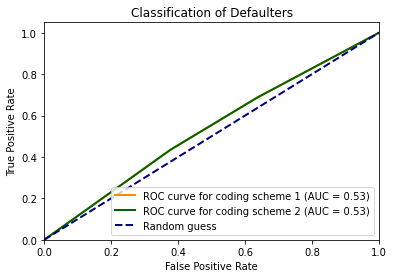

In [39]:
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_dummy_p = logit_dummy_res.predict(df_log1[['Intercept','Source Verified','Verified']])
roc_p = roc_curve(df_log1["loan_status"], predict_p)
roc_dummy_p = roc_curve(df_log1["loan_status"], predict_dummy_p)
auc_p = auc( roc_p[0], roc_p[1] )
auc_dummy_p = auc( roc_dummy_p[0], roc_dummy_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='ROC curve for coding scheme 1 (AUC = %0.2f)' % auc_p)
plt.plot(roc_dummy_p[0], roc_dummy_p[1], color='darkgreen',
         lw=lw, label='ROC curve for coding scheme 2 (AUC = %0.2f)' % auc_dummy_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

A partir de la figura, encontramos que ambos ROC tienen AUC bastante cercanas a 0.5, lo que confirma que `verification_status` por sí solo no es muy predictivo del estado del préstamo más allá de las conjeturas aleatorias. Esto también confirma que el primer esquema de codificación tiene un rendimiento idéntico al del segundo esquema de codificación. Dado que el primer esquema de codificación es más parco (es decir, contiene menos parámetros) que el segundo esquema, utilizaremos el primer esquema de codificación para el resto de este análisis.

### Ejercicio 7

Con base en los resultados anteriores (pseudo $R^2$ y AUC), ¿qué podemos concluir sobre el esquema de código apropiado para `verification_status`?

**Respuesta.** No hay diferencia en las dos métricas al comparar los dos esquemas de codificación diferentes. En estadística, preferimos modelos simples y, por lo tanto, el primer esquema de codificación es apropiado. Tenga en cuenta que en el segundo esquema de codificación, necesitamos estimar un parámetro más que en el primer esquema de codificación.

## Agregando variables adicionales al modelo

En la sección anterior, verificamos que efectivamente existe una tendencia decreciente en la probabilidad de pago asociada con información de ingresos más confiable. También realizamos dos enfoques de verificación de modelos y determinamos que la codificación de enteros para `verification_status` es adecuada. Sin embargo, la tendencia decreciente descubierta es contraria a la intuición. Esto podría deberse a que muchos otros factores también están asociados con la probabilidad de pago, como hemos visto en los análisis exploratorios. De manera similar a la regresión lineal, no tener en cuenta estos factores dará como resultado respuestas completamente diferentes para el efecto de `verification_status`, que ya se insinúa en las tablas de contingencia estratificadas.

Encontramos que a excepción de `annual_inc`, todas las demás variables en el conjunto de datos están correlacionadas con `verification_status`. Por ejemplo, parece haber una fuerte correlación entre `verification_status` y `loan_amnt`. Las personas sin fuente de ingresos verificada tienden a pedir prestado menos dinero que las personas con fuente de ingresos verificada. Esta podría ser la razón de la tendencia decreciente asociada con `verification_status`, ya que es más probable que se paguen los préstamos más pequeños. Ahora incorporemos todas estas variables (incluyendo `annual_inc` por ahora) en el modelo logístico junto con `verification_status` y veamos si la tendencia decreciente asociada con `verification_status` todavía está presente:

In [40]:
# Preprocesando las variables
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix="home", drop_first=True), \
                     pd.get_dummies(df.purpose, prefix="purpose", drop_first=True), \
                     pd.get_dummies(df.grade, prefix="grade",drop_first=True)], axis=1)
df_log2["verification_status"] = df.verification_status.cat.codes
df_log2["emp_length"] = df.emp_length.cat.codes
df_log2["term"] = df.term.cat.codes
df_log2["Intercept"] = 1

In [41]:
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()
print(logit_full1_res.summary())

Optimization terminated successfully.
         Current function value: 0.378075
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38676
Method:                           MLE   Df Model:                           28
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                 0.06869
Time:                        19:08:32   Log-Likelihood:                -14633.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                     -0.0075      0.019     -0.389      0.697      

### Ejercicio 8

Con base en los resultados del modelo logístico con todas las variables incluidas, ¿cuál de las siguientes conclusiones es correcta? Seleccione todas las que correspondan.

1. No hay evidencia que respalde la asociación entre la probabilidad de pago y el estado de verificación después de tener en cuenta otras variables.
2. Los préstamos para pequeñas empresas tienen la menor probabilidad de pago.
3. Las probabilidades de pago en los usuarios con grado B de LendingClub disminuyen en un 24 % en comparación con los usuarios con grado A después de tener en cuenta otras variables.

**Respuesta.** 1 es correcto ya que $p$ - el valor de la variable `verification_status` no es inferior a 0,05. 2 no es correcto ya que la afirmación no tiene en cuenta los efectos de otras variables. 3 es correcto ya que podemos calcularlo usando el coeficiente estimado.

### ¿Por qué observamos una tendencia marginal asociada con el estado de verificación?

Curiosamente, encontramos que el coeficiente de regresión para `verification_status` ahora es positivo y el valor de $p$ es muy grande (0.68). Esto indica que después de ajustar todas las demás variables en el conjunto de datos, `verification_status` ya no está significativamente asociado con la probabilidad de pago. Averigüemos ahora qué variables de confusión fueron las responsables de introducir la tendencia decreciente inicial que observamos.

Podemos investigar este problema utilizando los resultados de la regresión junto con la correlación entre `verification_status` y todas las demás variables. Primero, echemos un vistazo a la relación por pares entre `verification_status` y todas las demás variables:

In [42]:
def get_rctable(var1, var2):
    res = pd.crosstab(df[var2], df[var1])
    chi2, p, dof, ex = chi2_contingency(res)
    output = round( res.div(res.sum(axis = 1),axis = 0)*100, 2 )
    return output.style.set_caption("%s vs. %s: Chi-square p-value=%.2f" % (var1,var2,p))

In [43]:
display(get_rctable("emp_length", "verification_status"))
display(get_rctable("home_ownership", "verification_status"))
display(get_rctable("purpose", "verification_status"))
display(get_rctable("term", "verification_status"))
display(get_rctable("grade", "verification_status"))

emp_length,< 1 year,1 year,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,10+ years
verification_status,,,,,,,,,,,
Not Verified,12.090000,9.410000,12.430000,11.100000,8.980000,8.590000,5.670000,4.440000,3.820000,3.330000,20.130000
Source Verified,15.080000,8.520000,11.220000,10.710000,8.720000,8.480000,5.770000,4.650000,3.540000,3.030000,20.250000
Verified,8.990000,6.920000,10.020000,9.810000,8.940000,8.350000,5.880000,4.720000,4.080000,3.320000,28.980000


home_ownership,RENT,MORTGAGE,OWN,OTHER
verification_status,,,,
Not Verified,49.730000,41.590000,8.360000,0.320000
Source Verified,52.420000,40.020000,7.450000,0.100000
Verified,41.620000,52.180000,5.920000,0.290000


purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
verification_status,,,,,,,,,,,,,,
Not Verified,4.770000,13.470000,43.510000,1.350000,7.170000,0.830000,6.150000,1.800000,1.420000,12.100000,0.190000,3.950000,0.990000,2.290000
Source Verified,4.590000,12.030000,46.270000,0.330000,7.350000,1.000000,6.020000,2.080000,2.000000,9.310000,0.380000,4.570000,1.100000,2.980000
Verified,2.110000,12.950000,52.900000,0.510000,7.930000,1.080000,4.130000,1.360000,1.030000,7.480000,0.210000,5.530000,0.650000,2.130000


term,36 months,60 months
verification_status,,
Not Verified,85.790000,14.210000
Source Verified,69.460000,30.540000
Verified,59.010000,40.990000


grade,A,B,C,D,E,F,G
verification_status,,,,,,,
Not Verified,30.340000,31.980000,20.830000,11.630000,3.930000,1.030000,0.270000
Source Verified,25.300000,29.430000,19.950000,13.970000,7.760000,2.870000,0.710000
Verified,17.800000,28.500000,20.530000,15.520000,11.310000,4.710000,1.640000


<AxesSubplot:xlabel='verification_status', ylabel='loan_amnt'>

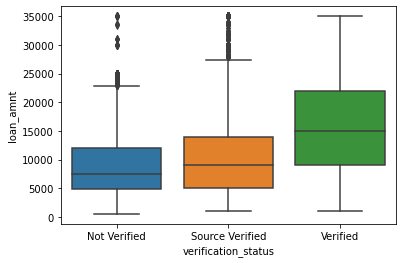

In [44]:
sns.boxplot(y="loan_amnt", x='verification_status', data = df)

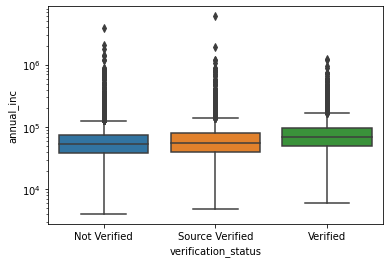

In [45]:
sns.boxplot(y="annual_inc", x='verification_status', data = df).set_yscale('log')

<AxesSubplot:xlabel='verification_status', ylabel='int_rate'>

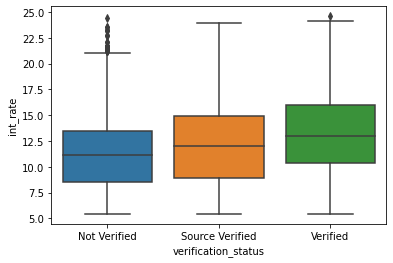

In [46]:
sns.boxplot(y="int_rate", x='verification_status', data = df)

# Ejercicio 9

Con base en las relaciones que observamos en las tablas de contingencia y los diagramas de caja anteriores, ¿cuáles de las siguientes afirmaciones son correctas? Seleccione todas las que correspondan.

A. La tendencia marginal es que las personas con ingresos verificados tienden a pedir préstamos con tasas de interés más altas.

B. La tendencia marginal es que las personas con ingresos verificados tienden a tener un empleo más prolongado

C. La tendencia marginal es que las personas con ingresos comprobados tienden a tener hipotecas

**Respuesta.** Tanto A como B son correctos, ya que la tasa de interés alta y la duración prolongada del empleo están asociados con una menor probabilidad de pago. C no es correcto ya que la propiedad de la vivienda no se asocia significativamente con la probabilidad de pago después de controlar otras variables.

## ¿Necesitamos incluir `verification_status`?

De lo anterior, podríamos llegar a la conclusión de que `verification_status` no importa cuando queremos predecir si un prestatario incumplirá con su deuda. Pero, ¿significa esto que, en el futuro, podemos simplemente ignorar el estado de verificación de un solicitante cuando presente una solicitud de préstamo a través de LC?

### Ejercicio 10

¿Cuál de las siguientes afirmaciones es verdadera con respecto a lo que debemos hacer con `verification_status`, según los resultados que tenemos hasta ahora?

A. Dado que el valor $p$ para `verification_status` es grande, podemos eliminarlo de nuestro modelo de clasificación y, en el futuro, no necesitamos recopilar esta parte de la información de los solicitantes.

B. Aunque el valor de $p$ para `verification_status` es grande, el coeficiente de regresión estimado para él es distinto de cero. Deberíamos mantener la variable en el modelo y continuar recopilando la información en el futuro.

C. Deberíamos llevar a cabo una evaluación adicional para comparar las precisiones de predicción del modelo con y sin `verification_status` antes de que podamos tomar cualquier otra decisión.

D. Ninguna de las anteriores.

**Respuesta.** A y B son incorrectos. No solo debemos basar nuestra decisión en el valor $p$ - solo. C es correcto.

Evaluemos la precisión de la predicción usando ROC. Los resultados se muestran a continuación:

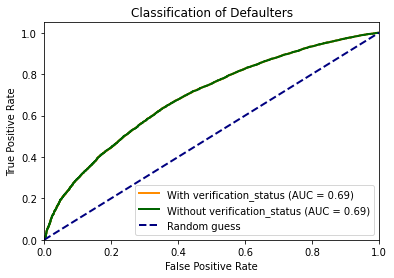

In [47]:
predict_withvs = logit_full1_res.predict(df_log2)
logit_full_novs = sm.Logit(df.loan_status.cat.codes, df_log2.loc[:, df_log2.columns != 'verification_status'])
predict_novs = logit_full_novs.fit(disp=0).predict(df_log2.loc[:, df_log2.columns != 'verification_status'])

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
roc_novs = roc_curve(df.loan_status.cat.codes, predict_novs)
auc_vs = auc( roc_vs[0], roc_vs[1] )
auc_novs = auc( roc_novs[0], roc_novs[1])

plt.figure()
lw = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=lw, label='With verification_status (AUC = %0.2f)' % auc_vs)
plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
         lw=lw, label='Without verification_status (AUC = %0.2f)' % auc_novs)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 11

Con base en todos los resultados anteriores, ¿qué podemos concluir sobre el proceso de verificación?

**Respuesta.** Encontramos que el AUC para el modelo con `verification_status` incluido es el mismo que el modelo sin `verification_status` incluido (0.69). Dado que siempre queremos que nuestro modelo sea lo más simple posible, esto significa que no debemos incluir `verification_status` como una variable al predecir si es probable que un usuario pague su deuda.


## Conclusiones

En este caso, investigamos si el estado de verificación de la fuente de ingresos de los solicitantes es importante al predecir si un solicitante pagará su deuda. Construimos un modelo logístico para examinar primero la relación marginal entre el estado de verificación y la probabilidad de pago. Descubrimos una tendencia contraria a la intuición: la información de fuente de ingresos menos confiable se correlacionó con una mayor probabilidad de pago. Sin embargo, después de ajustar un modelo logístico más grande con todas las variables independientes disponibles, encontramos que esta tendencia se introdujo a través de los efectos de confusión de la tasa de interés, el ingreso anual y el plazo del préstamo.

Después de tener en cuenta estas variables, el estado de verificación ya no se asoció significativamente con la probabilidad de pago. Con base en los valores de $p$ y el modelo ROC, llegamos a la conclusión de que el proceso de verificación es irrelevante y que potencialmente podríamos eliminarlo de los elementos requeridos y simplificar el proceso de préstamo.

## Para llevar

La regresión logística amplía naturalmente el concepto de regresión lineal y es el modelo de referencia para realizar tareas de clasificación. Los coeficientes tienen una interpretación similar a la de la regresión lineal. Las curvas ROC son útiles para comparar diferentes modelos de clasificación.